In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import shap
from pathlib import Path

from biopsykit.classification.model_selection import SklearnPipelinePermuter

from src.pepbench.io import get_best_estimator

from src.pepbench.io import compute_shap_values

In [2]:
model_path = Path("../../../results/models/b-point")
data_path = Path("../../../results/data/b-point")

In [3]:
pipeline_permuter = SklearnPipelinePermuter.from_pickle(model_path.joinpath("without-rr-interval/b_point_regression_hpc_0_baseline_result.pkl"))
pipeline_permuter.metric_summary()

conf_matrix  \
pipeline_scaler pipeline_reduce_dim pipeline_clf                        
StandardScaler  SelectFromModel     DecisionTreeRegressor       [0.0]   
                                    RandomForestRegressor       [0.0]   
                                    SVR                         [0.0]   
                                    KNeighborsRegressor         [0.0]   
                SelectKBest         DecisionTreeRegressor       [0.0]   
                                    RandomForestRegressor       [0.0]   
                                    SVR                         [0.0]   
                                    KNeighborsRegressor         [0.0]   
MinMaxScaler    SelectFromModel     DecisionTreeRegressor       [0.0]   
                                    RandomForestRegressor       [0.0]   
                                    SVR                         [0.0]   
                                    KNeighborsRegressor         [0.0]   
                SelectKBest         DecisionTreeRegressor       [0.0]   
                                    RandomForestRegressor       [0.0]   
                                    SVR                         [0.0]   
                                    KNeighborsRegressor         [0.0]   

                                                          conf_matrix_folds  \
pipeline_scaler pipeline_reduce_dim pipeline_clf                              
StandardScaler  SelectFromModel     DecisionTreeRegressor                []   
                                    RandomForestRegressor                []   
                                    SVR                                  []   
                                    KNeighborsRegressor                  []   
                SelectKBest         DecisionTreeRegressor                []   
                                    RandomForestRegressor                []   
                                    SVR                                  []   
                                    KNeighborsRegressor                  []   
MinMaxScaler    SelectFromModel     DecisionTreeRegressor                []   
                                    RandomForestRegressor                []   
                                    SVR                                  []   
                                    KNeighborsRegressor                  []   
                SelectKBest         DecisionTreeRegressor                []   
                                    RandomForestRegressor                []   
                                    SVR                                  []   
                                    KNeighborsRegressor                  []   

                                                                                                 true_labels  \
pipeline_scaler pipeline_reduce_dim pipeline_clf                                                               
StandardScaler  SelectFromModel     DecisionTreeRegressor  [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                                    RandomForestRegressor  [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                                    SVR                    [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                                    KNeighborsRegressor    [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                SelectKBest         DecisionTreeRegressor  [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                                    RandomForestRegressor  [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                                    SVR                    [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                                    KNeighborsRegressor    [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
MinMaxScaler    SelectFromModel     DecisionTreeRegressor  [370.0, 346.0, 374.0, 316.0, 336.0, 322.0, 334...   
                                    RandomForestRegressor  [370.0, 346.0, 374.0, 316.0, 

In [4]:
_, best_estimator_combi = get_best_estimator(pipeline_permuter)
best_estimator_combi

('StandardScaler', 'SelectKBest', 'RandomForestRegressor')

### Get the pipeline folds for the best performing pipeline combination

In [5]:
best_estimator_summary = pipeline_permuter.best_estimator_summary()
pipeline_folds = best_estimator_summary.loc[best_estimator_combi]["best_estimator"].pipeline
pipeline_folds

[Pipeline(memory=Memory(location=cachedir/joblib),
          steps=[('scaler', StandardScaler()),
                 ('reduce_dim',
                  SelectKBest(score_func=<function f_regression at 0x000001E799FF0FE0>)),
                 ('clf',
                  RandomForestRegressor(criterion='friedman_mse',
                                        max_features=0.5,
                                        min_impurity_decrease=0.001,
                                        n_estimators=400,
                                        random_state=RandomState(MT19937) at 0x1E7D1FF6440))]),
 Pipeline(memory=Memory(location=cachedir/joblib),
          steps=[('scaler', StandardScaler()),
                 ('reduce_dim',
                  SelectKBest(score_func=<function f_regression at 0x000001E799FF0FE0>)),
                 ('clf',
                  RandomForestRegressor(max_depth=np.int64(30), max_features=0.8,
                                        min_samples_split=10, n_estimators=150,
 

### Get the test folds used in the pipeline permuter

In [6]:
test_folds = pipeline_permuter.metric_summary().loc[best_estimator_combi]["test_indices_folds"]
test_folds

array([array([2257, 2258, 2259, ..., 8625, 8626, 8627], shape=(1996,)),
       array([ 319,  320,  321, ..., 7928, 7929, 7930], shape=(2106,)),
       array([  545,   546,   547, ..., 10394, 10395, 10396], shape=(2046,)),
       array([ 843,  844,  845, ..., 8188, 8189, 8190], shape=(2125,)),
       array([    0,     1,     2, ..., 10139, 10140, 10141], shape=(2124,))],
      dtype=object)

### Load the training data

In [7]:
data = pd.read_csv(data_path.joinpath("without-rr-interval/train_data_b_point.csv"), index_col=[0,1,2,3,4,5])
data

,,,,,,arbol2017-isoelectric-crossings,arbol2017-second-derivative,arbol2017-third-derivative,debski1993-second-derivative,drost2022,forounzafar2018,lozano2007-linear-regression,lozano2007-quadratic-regression,sherwood1990,stern1985
,participant,condition,phase,heartbeat_id_reference,b_point_sample_reference,,,,,,,,,,
0,GDN0005,Dummy,HoldingBreath,0,388.0,438.0,398.0,394.0,452.0,400.0,550.0,412.0,384.0,442.0,388.0
1,GDN0005,Dummy,HoldingBreath,1,404.0,340.0,350.0,244.0,388.0,420.0,402.0,404.0,384.0,330.0,402.0
2,GDN0005,Dummy,HoldingBreath,3,376.0,382.0,296.0,386.0,366.0,386.0,388.0,366.0,348.0,382.0,374.0
3,GDN0005,Dummy,HoldingBreath,4,390.0,394.0,344.0,396.0,376.0,396.0,398.0,372.0,348.0,394.0,388.0
4,GDN0005,Dummy,HoldingBreath,5,386.0,398.0,312.0,388.0,418.0,392.0,390.0,378.0,354.0,400.0,384.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11606,VP_032,tsst,Talk,39,310.0,335.0,276.0,324.0,300.0,318.0,306.0,305.0,294.0,337.0,306.0
11607,VP_032,tsst,Talk,40,322.0,331.0,298.0,330.0,311.0,322.0,311.0,321.0,303.0,329.0,287.0
11608,VP_032,tsst,Talk,41,340.0,317.0,300.0,348.0,330.0,343.0,309.0,332.0,322.0,311.0,287.0


<Axes: >

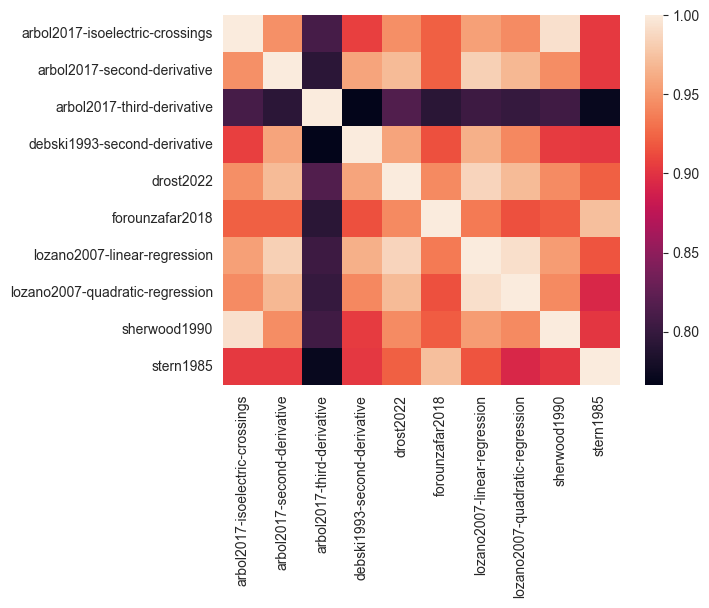

In [8]:
sns.heatmap(data=data.corr())

## Compute SHAP values

In [12]:
shap_per_fold_best_algo, test_folds_best_algo, pipeline_folds_best_algo = compute_shap_values(pipeline_permuter, data, best_estimator_combi)

In [13]:
shap_values_best_algo = np.concatenate(shap_per_fold_best_algo)

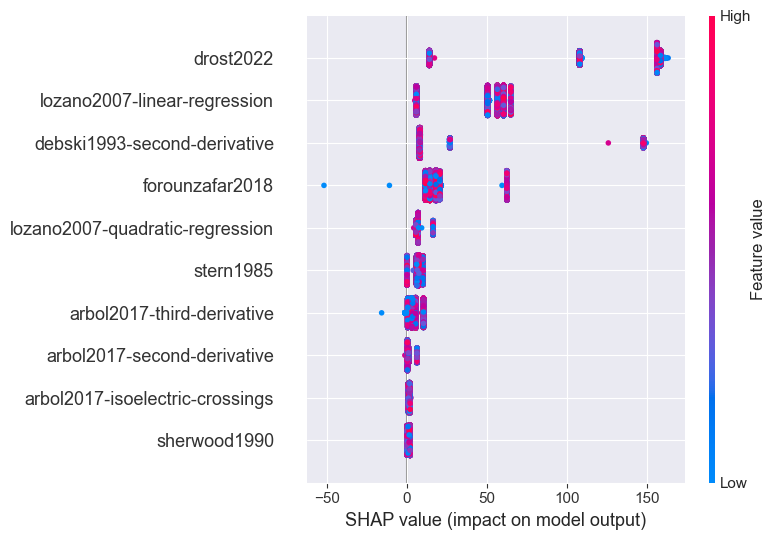

In [14]:
features = data.iloc[list(np.concatenate(test_folds_best_algo)), :].values
feature_names = data.columns
shap.summary_plot(
    shap_values_best_algo, features=features, feature_names=feature_names
)

#### Show summary_plot for one fold

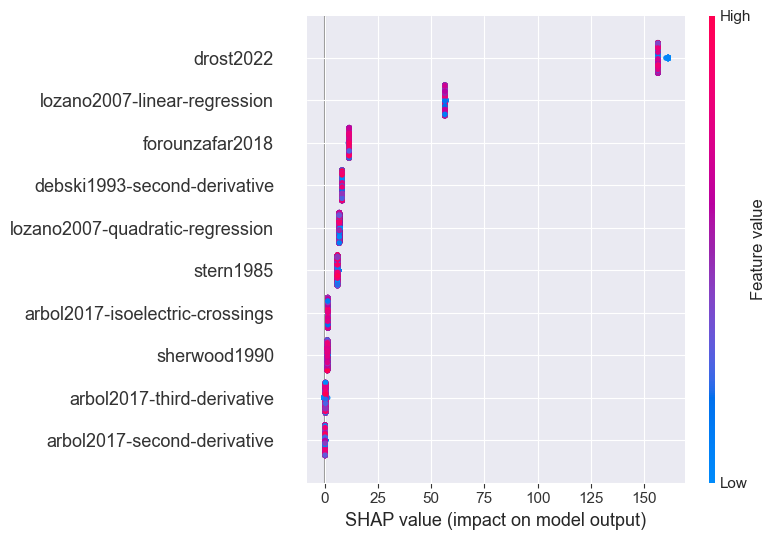

In [19]:
features = data.iloc[list(test_folds[4]), :].values
feature_names = data.columns
shap.summary_plot(
    shap_per_fold_best_algo[4], features=features, feature_names=feature_names
)

In [9]:
shap_per_fold_svr, test_folds_svr, pipeline_folds_svr, _, feature_names = compute_shap_values(pipeline_permuter, data, ('StandardScaler', 'SelectFromModel', 'RandomForestRegressor'))

Index(['debski1993-second-derivative', 'drost2022', 'forounzafar2018',
       'lozano2007-linear-regression', 'stern1985'],
      dtype='object')
Index(['debski1993-second-derivative', 'drost2022', 'forounzafar2018',
       'lozano2007-linear-regression', 'stern1985'],
      dtype='object')
Index(['debski1993-second-derivative', 'drost2022', 'forounzafar2018',
       'lozano2007-linear-regression', 'stern1985'],
      dtype='object')
Index(['debski1993-second-derivative', 'drost2022', 'forounzafar2018',
       'lozano2007-linear-regression', 'stern1985'],
      dtype='object')
Index(['debski1993-second-derivative', 'drost2022', 'forounzafar2018',
       'lozano2007-linear-regression', 'lozano2007-quadratic-regression'],
      dtype='object')


In [10]:
shap_values_svr = np.concatenate(shap_per_fold_svr)
shap_values_svr

array([[ 32.88924728,  91.35117304,  36.58693849,  79.13333294,
         12.09759772],
       [ 32.88924728,  91.35117304,  36.58693849,  79.13333294,
         12.09759772],
       [ 32.88924728,  91.35117304,  36.58693849,  79.13333294,
         12.09759772],
       ...,
       [  6.4881765 , 162.57356098,  16.20922731,  68.3782467 ,
          7.75165831],
       [  6.4881765 , 162.57356098,  16.20922731,  68.3782467 ,
          7.75165831],
       [  6.4881765 , 162.57356098,  16.20922731,  68.3782467 ,
          7.75165831]], shape=(10397, 5))

In [15]:
feature_names[0]

Index(['debski1993-second-derivative', 'drost2022', 'forounzafar2018',
       'lozano2007-linear-regression', 'stern1985'],
      dtype='object')

In [13]:
data.iloc[list(np.concatenate(test_folds_svr)), :]

,,,,,,arbol2017-isoelectric-crossings,arbol2017-second-derivative,arbol2017-third-derivative,debski1993-second-derivative,drost2022,forounzafar2018,lozano2007-linear-regression,lozano2007-quadratic-regression,sherwood1990,stern1985
,participant,condition,phase,heartbeat_id_reference,b_point_sample_reference,,,,,,,,,,
2564,GDN0014,Dummy,HoldingBreath,0,370.0,382.0,288.0,384.0,366.0,378.0,218.0,374.0,368.0,386.0,332.0
2565,GDN0014,Dummy,HoldingBreath,1,346.0,370.0,292.0,376.0,336.0,372.0,238.0,376.0,370.0,366.0,236.0
2566,GDN0014,Dummy,HoldingBreath,2,374.0,334.0,318.0,396.0,372.0,390.0,268.0,372.0,366.0,338.0,232.0
2567,GDN0014,Dummy,HoldingBreath,3,316.0,346.0,290.0,366.0,352.0,364.0,266.0,364.0,356.0,342.0,234.0
2568,GDN0014,Dummy,HoldingBreath,4,336.0,358.0,274.0,350.0,332.0,354.0,334.0,360.0,354.0,362.0,334.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11340,VP_031,tsst,Talk,56,224.0,247.0,181.0,232.0,213.0,233.0,222.0,245.0,244.0,247.0,222.0
11341,VP_031,tsst,Talk,57,225.0,243.0,183.0,232.0,212.0,231.0,222.0,243.0,243.0,241.0,222.0
11342,VP_031,tsst,Talk,58,221.0,248.0,191.0,232.0,212.0,229.0,190.0,244.0,244.0,252.0,167.0


#### Visualize shap values on a fold basis

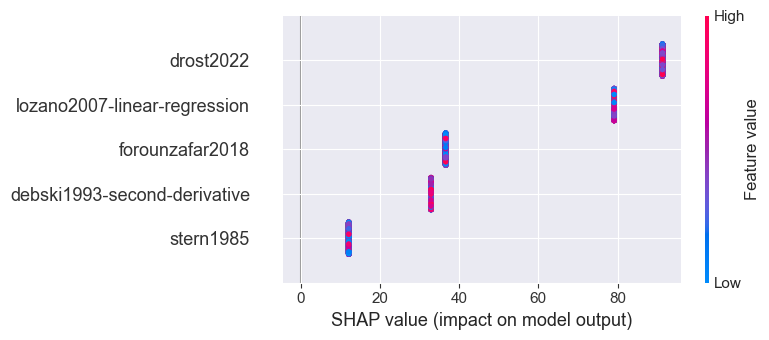

In [27]:
features = data.iloc[list(test_folds_svr[0]), :][feature_names[0]].values
shap.summary_plot(
    shap_per_fold_svr[0], features=features, feature_names=feature_names[0]
)

In [ ]:
shap.force_plot()